In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tables
from time import time
import pickle


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ShuffleSplit, train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import roc_auc_score

import xgboost as xgb
import lightgbm as lgb
import featuretools as ft


from helper import *
from time import time

#update_unknown_to_nan
# magic word for producing visualizations in notebook
%matplotlib inline

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).



In [2]:
customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str',19:'str'})
customers.head(3) #lot many features and many having nan

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4


In [3]:
%%time
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str',19:'str'})
azdias.head()

CPU times: user 15.5 s, sys: 1.27 s, total: 16.8 s
Wall time: 16.8 s


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. 
Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
print ('(#individuals ,#features)->', azdias.shape)

(#individuals ,#features)-> (891221, 366)


In [5]:
print ('(#customers ,#features)->', customers.shape)

(#customers ,#features)-> (191652, 369)


# Data Exploration

1) In first step, the features are dropped which are not in both dataset, so that both dataset the general population and customers have the same number of features. The following features are not contained in general population, hence dropped: ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

In [6]:
print ('customer dataset shape', customers.shape)
customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],
                axis=1,
                inplace=True)

customer dataset shape (191652, 369)


2) In the second step, the missing and unknown values need to be found out. The following figure shows the percentage of not available values per feature in both customer and general population dataset.

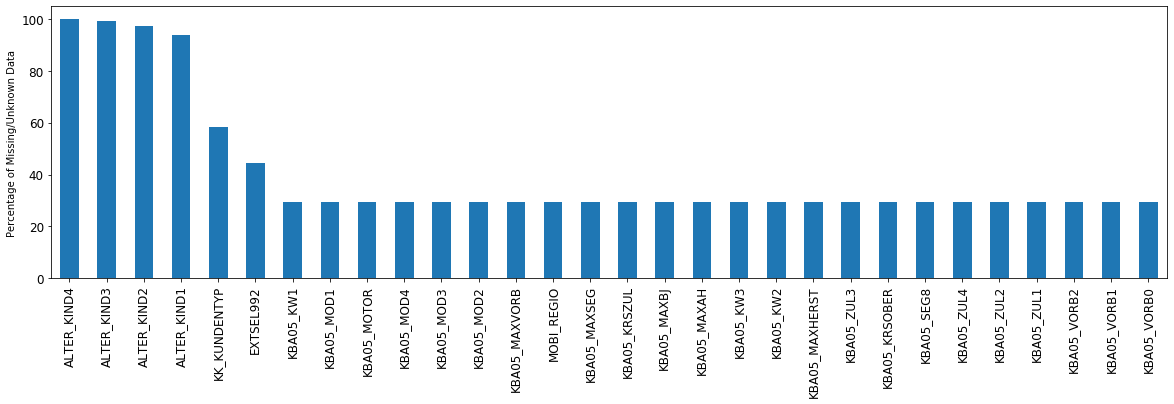

In [7]:
#show percentage of null data of 191T customer for each features
plot_miss_val(customers, top_n=30)

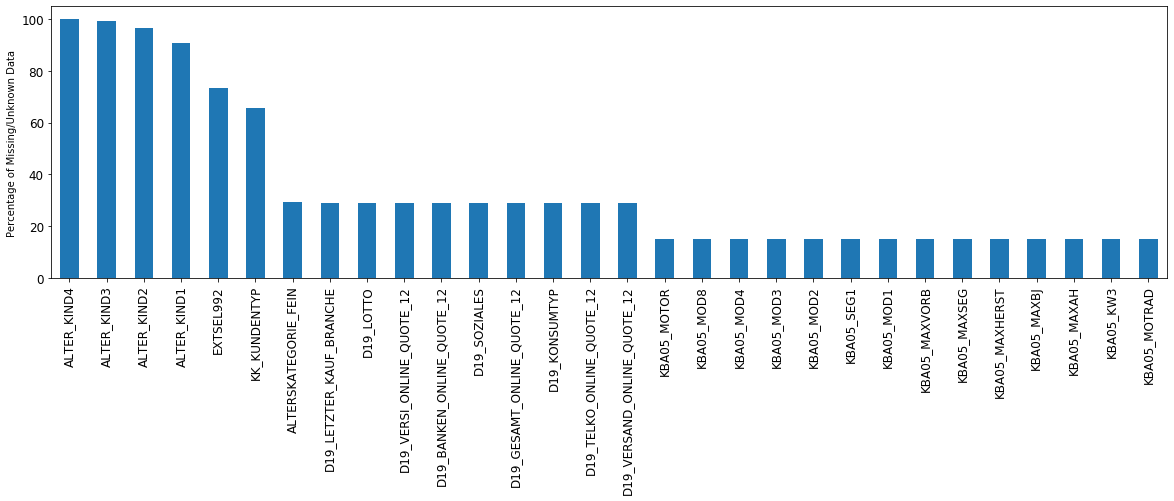

In [8]:
#show percentage of null data of general population for each features
plot_miss_val(azdias, top_n=30)

3) The attrbutes information has been entered in a csv file 'data/feat_summary.csv'. The information contains feature type, missing or unknown value code (e.g. 9, X, XX), and type (e.g. numeric or ordinal). This is used in cleaning the data set. After applying, this information there are more features with higher percentage of unknowns.

In [9]:
feat_info = pd.read_csv('data/feat_summary.csv', sep=',')

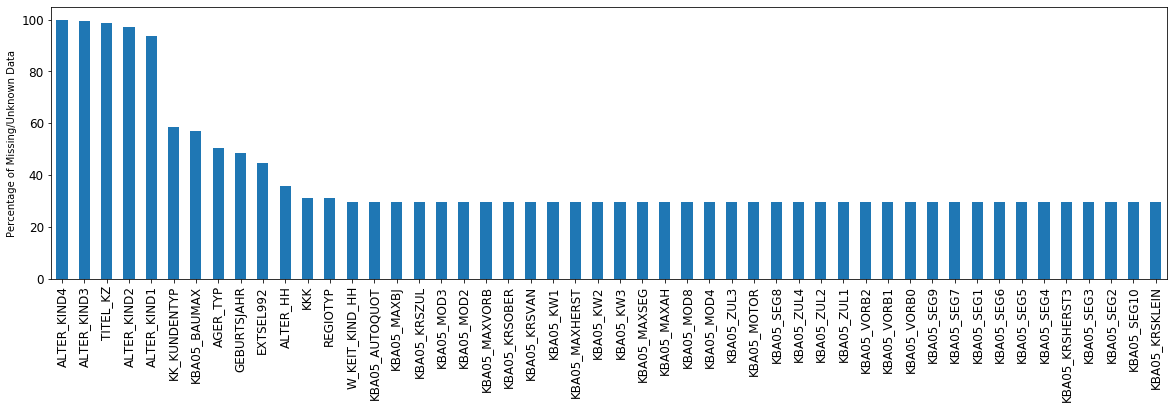

In [10]:

#update the missing and unknown values e.g. -1 as null
customers = update_unknown_to_nan(customers, feat_info)
#show missing values after checking for missing and unknown values in dataset
plot_miss_val(customers, top_n=50)

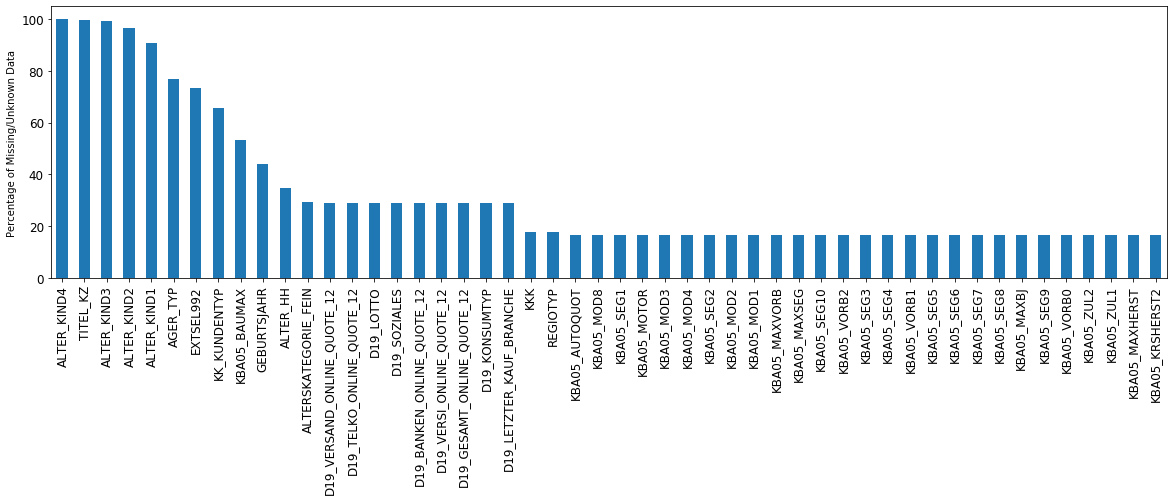

In [11]:
#update the missing and unknown values e.g. -1 as null
azdias = update_unknown_to_nan(azdias, feat_info)
#show missing values after checking for missing and unknown values in dataset
plot_miss_val(azdias, top_n=50)

4) In the fourth step, we decided to 
    - drop data point with more than 13 feature values missing
    - drop features with more than 30 percent of data points missing

The reason was to minimize the impact of the imputation strategy on the unsupervised learning model.

In [12]:
# Remove rows with incomplete customer information (e.g. 13 feature data missing)
cust_optrows = customers.dropna(thresh=353) # requires 
print ('#customer rows with max 13 non-NA values:', cust_optrows.shape[0])

#customer rows with max 13 non-NA values: 125912


In [13]:
azdias_optrows = azdias.dropna(thresh=353)
print ('#general population rows with max 13 non-NA values:', azdias_optrows.shape[0])

#general population rows with max 13 non-NA values: 543666


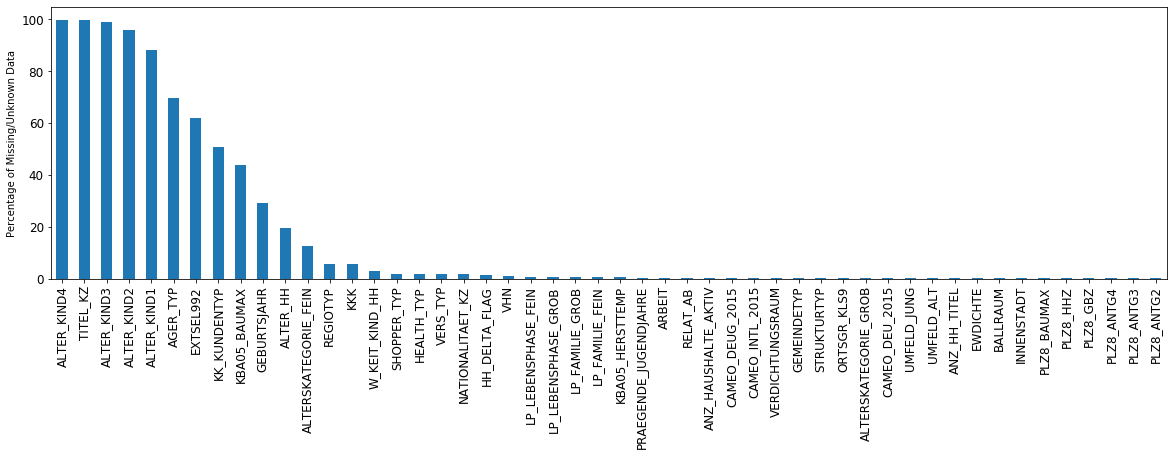

In [14]:
#show missing values after checking for missing and unknown values in dataset
plot_miss_val(azdias_optrows, top_n=50)

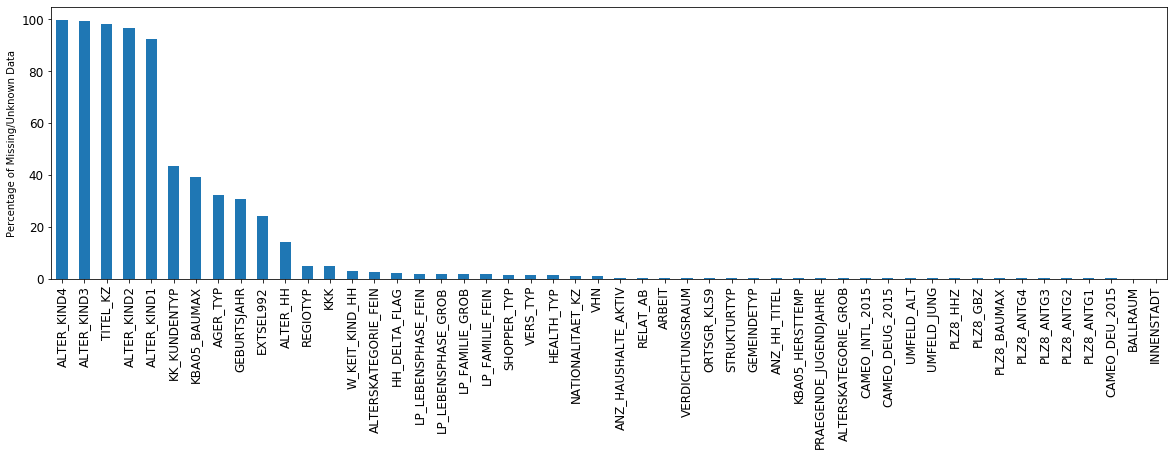

In [15]:
plot_miss_val(cust_optrows, top_n=50)

## Remove columns with more than 30% missing values

In [16]:
#Drop columns with outlier number of missing columns
customer_cols_drop = (cust_optrows.isnull().sum()/len(cust_optrows)).sort_values(ascending=False).where(lambda x: x > .30).dropna().index.tolist()
azdias_cols_drop = (azdias_optrows.isnull().sum()/len(azdias_optrows)).sort_values(ascending=False).where(lambda x: x > .30).dropna().index.tolist()
cols_drop = list(set(customer_cols_drop) | set(azdias_cols_drop))
print ('Columns to be dropped:',cols_drop)

Columns to be dropped: ['EXTSEL992', 'KK_KUNDENTYP', 'GEBURTSJAHR', 'ALTER_KIND1', 'ALTER_KIND4', 'ALTER_KIND3', 'KBA05_BAUMAX', 'AGER_TYP', 'ALTER_KIND2', 'TITEL_KZ']


In [17]:
 print ('-------customers dataset-------------')
cust_opt = drop_col(cust_optrows, cols_drop)

-------customers dataset-------------
dataset shape before dropping (125912, 366)
dataset shape after dropping (125912, 356)


In [18]:
print ('-------population dataset-------------')
azdias_opt = drop_col(azdias_optrows, cols_drop)

-------population dataset-------------
dataset shape before dropping (543666, 366)
dataset shape after dropping (543666, 356)


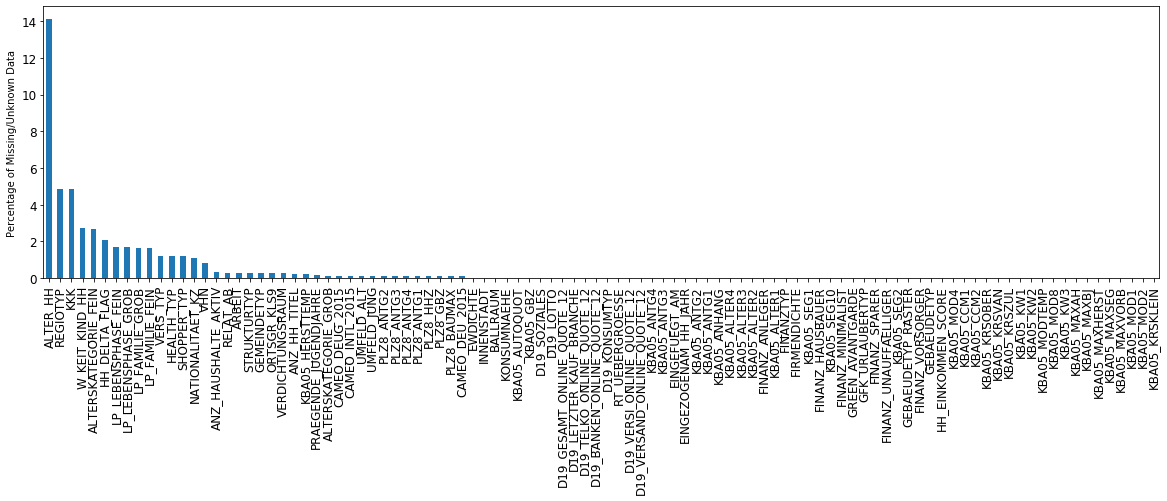

In [19]:
plot_miss_val(cust_opt, top_n=100)

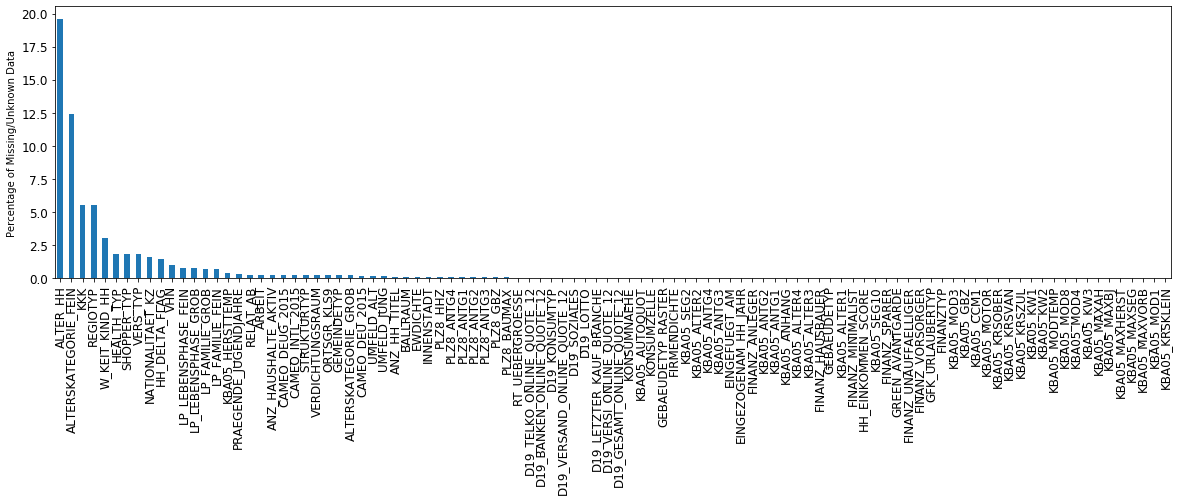

In [20]:
plot_miss_val(azdias_opt, top_n=100)

In [21]:
azdias_opt.shape

(543666, 356)

5) After dropping data points we obtain
    - a general population dataset containing 356 features instead of 366, and almost 39 percent lesser data points. Futhermore, the percentave of missing data is less than 5 percent for all but 2 features.
    - a customer dataset containing 356 features instead of 366 and 34 percent lesser data points. Futhermore, the percentage of missing data is less than 5 percent for all but 1 features

The categorical feature types need to be identified, which should be encoded as dummy variable. They have a significant impact later on the model accuracy later. 
- There are 50 categorical variables of which 41 are used in the customer data set.

In [22]:
azdias_opt.dtypes.value_counts()
azdias_opt.select_dtypes(include=["object"]).columns.values

array(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype=object)

1) Of the 41 categorical features, the 6 features with object datatype are handled with preprocessing helper function. e.g. ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']
The above object types are are preprocess using a helper function to do the following:
- drop CAMEO_DEU_2015 as the same information is also in other CAMEO attributes.
- extract the year information from 'EINGEFUEGT_AM' attribute
- Convert 'OST_WEST_KZ' from string to binary form
- 'CAMEO_INTL_2015' is split into wealth status and life phase attribute
- Furthermore, 48 features are not described. Dropping features not described was not considered as an option as many like ANZ_KINDER, i.e. number of childs sound promising.
- as unsupervised learning methods like pca and kmeans take quite some time, therefore the only half of general population was sampled and the preprocessed for further use.

In [23]:
customers_p = preprocessing(cust_opt)

In [24]:
%%time
#due to long execution time only 50% of sample taken
sample_azdias = azdias_opt.sample(frac=0.5, random_state=42)
#handle object dtypes
azdias_p = preprocessing(sample_azdias)

CPU times: user 2.83 s, sys: 457 ms, total: 3.29 s
Wall time: 3.29 s


In [25]:
#feat_info['type'].value_counts()

#cat_vars = feat_info[feat_info['type'] == 'categorical'].attribute.tolist()
#feat_in_dataset = cust_opt.columns.values
#feat_described = feat_info.attribute.tolist()
#feat_not_described = np.setdiff1d(feat_in_dataset,feat_described)
#len(feat_not_described)
#feat_described_in_both = np.intersect1d(cat_vars,feat_in_dataset)
#cols = feat_described_in_both
#cols

Instead of changing the type categorical in excel feat_summary, the categorical variables were defined within the notebook.

In [26]:
cols = [
 'CAMEO_INTL_2015_STANDARD',
 'CAMEO_INTL_2015_LEBENSPHASE',
 #'CAMEO_DEUG_2015',   
 'CJT_GESAMTTYP',
 'D19_KONSUMTYP', 
 #'D19_LETZTER_KAUF_BRANCHE',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GEMEINDETYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'KOMBIALTER',
 'LP_FAMILIE_GROB',   
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',   
 'PRAEGENDE_JUGENDJAHRE_BEWEGUNG',
 'PRAEGENDE_JUGENDJAHRE_DEKADE',
 'SHOPPER_TYP',  
 'ZABEOTYP']



2) The preprocessing pipeline in following function consists of following stages
- imputation: filling missing values. Here, replacing with most frequent occuring value. Changed to fill missing with zero. However, this had almost no impact of percentage of missing values in quite less.
- encoding: one hot encoding of the categorical value. There are 41 categorical features, however they are very often ordinal in nature. Therefore, one can experiment by manually selecting the categorical features as done above using 'cols' variable
- scaling: used standard scaler.

The above steps are carried out in preprocess_pipeline function with cols as parameter containing the categorical features.

In [27]:
%%time
# imputation, encoding and scaling of customer data
scaler_c, customers_df_imputed_enc_scaled = preprocess_pipeline(customers_p, cols)

CPU times: user 12.4 s, sys: 3.33 s, total: 15.8 s
Wall time: 15.8 s


In [28]:
#print ([name for name in customers.columns.values if 'RESP' in name])
customers_df_imputed_enc_scaled.shape

(125912, 441)

In [29]:

#imputation, encoding, and scaling
scaler_p, azdias_df_imputed_enc_scaled = preprocess_pipeline(azdias_p, cols)

In [30]:
azdias_df_imputed_enc_scaled.shape

(271833, 441)

After preprocessing, there is significant increase in number of features due to introduction of dummy variable for categorical features. Very often, certain dummy variables are not existing in both dataset as certain categorical variable value may be absent in both dataset. Therefore, following cell is to find if same features are in both customer and general population data set

In [31]:
#DEBUG: to find if same features are in both customer and general population data set
feat_azdias = azdias_df_imputed_enc_scaled.columns.values.tolist()
feat_cust = customers_df_imputed_enc_scaled.columns.values.tolist()
feat_not_described = np.setdiff1d(feat_cust, feat_azdias)
print (feat_not_described)
for feat in feat_not_described:
    if feat in feat_cust:
        azdias_df_imputed_enc_scaled[feat] = 0
    else:
        customers_df_imputed_enc_scaled[feat] = 0
#azdias_df_imputed_enc_scaled.shap


[]


# Part 1: Customer Segmentation Report
The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Stage 1: Reduce Dimensionality of data 

Principal component analysis is used to reduce dimensionality of the data.

In [32]:
# apply principal component analysis with n components
def pca_fit_transform(df, n, show_plot=0):
    '''performs principal component analysis of input data frame
        
    Args:
        df: input dataframe
        n: number of principal components.
        show_plot: if 1 then show plot explained variance vs number of components, else print
        
    Returns:
        df_pca: Fit the n component pca model with input dataframe (df) and apply the dimensionality reduction on df.
        pca_n: n component pca model
    '''
    pca_n = PCA(n)
    # fit transform
    df_pca = pca_n.fit_transform(df)
    variance = pca_n.explained_variance_ratio_
    cumulative_variance=np.cumsum(np.round(variance, decimals=3)*100)
    if show_plot:
        plt.figure(figsize=(20,4))
        plt.plot(np.cumsum(pca_n.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('cumulative variance explained')
        plt.show()
    else:
        print (cumulative_variance[-1], 'of variance explained by n comps,n=', n)
    return df_pca, pca_n


    

In [83]:
%%time
n_components = 280
azdias_pca, pca_n = pca_fit_transform(azdias_df_imputed_enc_scaled, n_components, 0) 
azdias_pca.shape

95.89999999999971 of variance explained by n comps,n= 280
CPU times: user 1min 8s, sys: 5.51 s, total: 1min 14s
Wall time: 25.6 s


(271833, 280)

In [34]:
#pca_n.explained_variance_ratio_

Note we apply only dimensionality reduction below and not fit the pca with customer data.

In [35]:
customers_pca = pca_n.transform(customers_df_imputed_enc_scaled) 
customers_pca.shape

(125912, 280)

In [71]:
def pca_info(df, pca, component_num, features_num):
    pca_component = pd.DataFrame(np.round(pca.components_,3))
    return

#pca_info(azdias_df_imputed_enc_scaled, pca_n, 0, 3)
#first component
df = pd.DataFrame(pca_n.components_, columns = azdias_df_imputed_enc_scaled.keys()).iloc[0]
df.sort_values(inplace=True)
print ('\nfirst component\n', df)
#second component
df = pd.DataFrame(pca_n.components_, columns = azdias_df_imputed_enc_scaled.keys()).iloc[1]
df.sort_values(inplace=True)
print ('\nsecond component\n', df)
#third component
df = pd.DataFrame(pca_n.components_, columns = azdias_df_imputed_enc_scaled.keys()).iloc[2]
df.sort_values(inplace=True)
print ('\nthird component\n', df)
#fourth component
df = pd.DataFrame(pca_n.components_, columns = azdias_df_imputed_enc_scaled.keys()).iloc[3]
df.sort_values(inplace=True)
print ('\nfourth component\n', df)


first component
 MOBI_REGIO       -0.140544
LP_STATUS_FEIN   -0.133564
PLZ8_ANTG1       -0.133082
KBA13_ANTG1      -0.132628
KBA05_ANTG1      -0.130435
                    ...   
PLZ8_BAUMAX       0.127135
KBA13_ANTG4       0.128518
KBA13_BAUMAX      0.128804
KBA13_ANTG3       0.130944
PLZ8_ANTG3        0.131919
Name: 0, Length: 441, dtype: float64

second component
 FINANZ_VORSORGER       -0.151137
KOMBIALTER_4           -0.149506
CJT_TYP_5              -0.148052
CJT_TYP_4              -0.147157
ALTERSKATEGORIE_GROB   -0.143828
                          ...   
FINANZ_ANLEGER          0.143361
ONLINE_AFFINITAET       0.157773
CJT_TYP_2               0.159797
CJT_TYP_1               0.162013
FINANZ_SPARER           0.162955
Name: 1, Length: 441, dtype: float64

third component
 KBA13_SITZE_5                 -0.147832
KBA13_KMH_140_210             -0.126096
KBA13_SEG_KLEINWAGEN          -0.125612
KBA13_HALTER_25               -0.118640
KBA13_HALTER_20               -0.113596
           

In the first principal components, Number of family houses in the PLZ8 region and lmobility are very important features,e.g. positive PLZ8_ANTG3 , negative MOBI_REGIO (negative). In the second principal components, financial character is important, e.g. positive FINANZ_SPARER, negative FINANZ_SPARER.  In the third principal components, type of car is important, e.g. positive KBA13_HERST_BMW_BENZ, negative KBA13_SITZE_5.

## Stage 2: Find optimal number of cluster

Using Kmeans needs a long computation time for large population data-set. One can use either subsample of the data-set or use MiniBatchKMeans which is faster.

In [36]:
%%time
n_clusters = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
score = [] #metric sum of all distance of samples to cluster center
for n in n_clusters:
    kmeans =  MiniBatchKMeans(n_clusters=n, batch_size=200)
    model = kmeans.partial_fit(azdias_df_imputed_enc_scaled)
    val = np.abs(model.score(azdias_df_imputed_enc_scaled))
    score.append(val)
    print (n, val)
print (score)

4 112257886.72374754
6 109579285.58317593
8 106967178.10594703
10 106222550.17835638
12 105599210.94088583
14 104408045.37796605
16 104224280.29495065
18 103354291.09223115
20 102993143.31785735
22 102689046.79323496
24 101310165.19337198
26 101740371.03978842
28 101612413.48186813
[112257886.72374754, 109579285.58317593, 106967178.10594703, 106222550.17835638, 105599210.94088583, 104408045.37796605, 104224280.29495065, 103354291.09223115, 102993143.31785735, 102689046.79323496, 101310165.19337198, 101740371.03978842, 101612413.48186813]
CPU times: user 2min 48s, sys: 2.82 s, total: 2min 51s
Wall time: 52.7 s


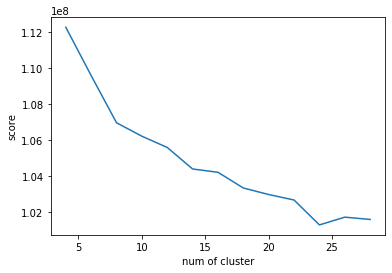

In [37]:
data = list(zip(n_clusters, score))
df = pd.DataFrame (data,columns=['num of cluster','score'])
sns.lineplot(x="num of cluster", y="score", data=df)

## Stage 3: K-means Clustering

Looking at the plot, one can select appropriate number of cluster tradeoff by using elbow method. Once the trade-off point is found, one can apply the Kmeans and fit model for population data. Since the fit takes a long time, therefore one can serialize the model for future use.

In [38]:
%%time
n = 8
kmeans =  KMeans(n)
model = kmeans.fit(azdias_pca)

CPU times: user 10min 39s, sys: 9.3 s, total: 10min 48s
Wall time: 3min 11s


In [39]:
#pickle.dump(model, open("model_kmeans_10.pkl", "wb"))
#model = pickle.load(open("model_kmeans_10.pkl", "rb"))

Finally predict the labels or clusters on the same data using the predict method of kmeans model. Each data point is assigned to a cluster. Similarly, the customer data points are also projected on the cluster

In [40]:
# 
predict_clusters_azdias = model.predict(azdias_pca)
series_azdias = pd.Series(predict_clusters_azdias)

In [41]:
series_azdias.value_counts().sort_values()

4    20124
2    22758
3    33062
1    33711
6    38281
5    38705
7    40608
0    44584
dtype: int64

In [42]:
predict_customers_clusters = model.predict(customers_pca)
series_customers = pd.Series(predict_customers_clusters)

In [43]:
#
series_customers.value_counts().sort_values()

4     6205
1     7476
2    10297
5    11221
6    18569
3    22192
0    24289
7    25663
dtype: int64

## Stage 4: Results

The following data frame and graphics shows the percentage of general population data and customer data in each cluster. It also shows which max cluster have higher and lower percentage (min cluster) of customer as compared to general population

In [44]:
# Create a dataframe from counts of data points within each population and customer clusters.
sum = len(customers_pca)
cust_pc = series_customers.value_counts().sort_index()/sum*100
sum = len(azdias_pca)
popu_pc = series_azdias.value_counts().sort_index()/sum*100
popu_pc
diff = cust_pc - popu_pc
compare_df = pd.concat([cust_pc, popu_pc, diff], axis=1).reset_index()
compare_df.columns = ['cluster', 'customer', 'population', 'diff']
#compare_df.index.name = 'cluster'
compare_df

,cluster,customer,population,diff
0,0,19.290457,16.401246,2.889210
1,1,5.937480,12.401364,-6.463884
2,2,8.177934,8.372052,-0.194118
3,3,17.625008,12.162615,5.462393
4,4,4.928045,7.403075,-2.475030
5,5,8.911780,14.238521,-5.326742
6,6,14.747601,14.082543,0.665058
7,7,20.381695,14.938584,5.443112


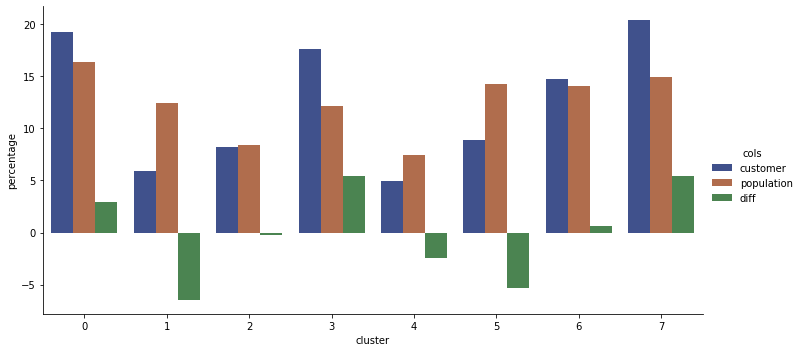

In [45]:
compare_df_melt = compare_df.melt('cluster', var_name='cols',  value_name='percentage')
g = sns.catplot(data=compare_df_melt, kind="bar", x="cluster", y="percentage",  hue="cols", 
                palette="dark", alpha=.8, aspect=2)


# Stage 5: Identify features 

which features of general population that are more likely to be part of the mail-order company's main customer base. On comparing the cluster center of overrated and underrated cluster pair, the features with significant difference show that following features are important.

positive correlated features ['ALTERSKATEGORIE_GROB', 'CAMEO_INTL_2015_STANDARD_1.0', 'CJT_GESAMTTYP_2.0', 'CJT_KATALOGNUTZER', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_SOZIALES', 'FINANZTYP_2', 'FINANZ_MINIMALIST', 'FINANZ_VORSORGER', 'KBA05_ANTG1', 'KBA05_KRSAQUOT', 'KBA05_MOTOR', 'KOMBIALTER_4', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN', 'LP_STATUS_GROB_5.0', 'MOBI_REGIO', 'PRAEGENDE_JUGENDJAHRE_DEKADE_2.0', 'PRAEGENDE_JUGENDJAHRE_DEKADE_3.0', 'PRAEGENDE_JUGENDJAHRE_DEKADE_4.0', 'RETOURTYP_BK_S', 'SEMIO_ERL', 'SEMIO_LUST', 'UMFELD_JUNG', 'WOHNDAUER_2008', 'ZABEOTYP_1', 'ZABEOTYP_3']

negative correlated features ['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'CAMEO_DEUG_2015', 'CJT_TYP_1', 'CJT_TYP_2', 'EINGEZOGENAM_HH_JAHR', 'FINANZTYP_1', 'FINANZ_ANLEGER', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'GFK_URLAUBERTYP_12.0', 'HH_EINKOMMEN_SCORE', 'KBA05_ALTER1', 'KBA13_BJ_2000', 'KBA13_KW_0_60', 'KOMBIALTER_1', 'KOMBIALTER_2', 'LP_STATUS_GROB_1.0', 'PRAEGENDE_JUGENDJAHRE_DEKADE_6.0', 'RT_KEIN_ANREIZ', 'RT_UEBERGROESSE', 'SEMIO_FAM', 'SEMIO_KULT', 'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_TRADV', 'VK_ZG11', 'ZABEOTYP_4', 'ZABEOTYP_5']

KBA13_SITZE_5                 -0.147832
KBA13_KMH_140_210             -0.126096
KBA13_SEG_KLEINWAGEN          -0.125612
KBA13_HALTER_25               -0.118640
KBA13_HALTER_20               -0.113596
                                 ...   
KBA13_SITZE_4                  0.145147
KBA13_BMW                      0.148526
KBA13_MERCEDES                 0.153454
KBA13_SEG_OBEREMITTELKLASSE    0.154105
KBA13_HERST_BMW_BENZ           0.178634
Name: 2, Length: 441, dtype: float64


In [80]:
def analyze_cluster(max_cluster, min_cluster, pca_n, cols):
    '''finds out important features by comparing the features in max and min cluster.
        
    Args:
        max_cluster: cluster with highest difference in customer and population distribution (overrated)
        min_cluster: cluster with lowest difference in customer and population distribution (underrated)
        pca_n: pca model with n components
        cols: column for updating index of inverse transformed cluster center
    Returns:
        imp_features_list_pos: features correlated to presence in customer intensive cluster
        imp_features_list_neg: features correlated to absence in customer intensive cluster
    '''
    cluster_max = pd.Series(kmeans.cluster_centers_[max_cluster])
    cluster_min = pd.Series(kmeans.cluster_centers_[min_cluster])
    
    cluster_max_center = (pca_n.inverse_transform(cluster_max))
    cluster_min_center = (pca_n.inverse_transform(cluster_min))
    s_cluster_max_center = scaler_p.inverse_transform(pca_n.inverse_transform(cluster_max))
    s_cluster_min_center = scaler_p.inverse_transform(pca_n.inverse_transform(cluster_min))
    
    df_cluster_max_center = pd.Series(cluster_max_center)
    df_cluster_max_center.index = cols
    df_cluster_min_center = pd.Series(cluster_min_center)
    df_cluster_min_center.index = cols
    #print (cluster_max.head(4), cluster_min.head(4))
    df_s_cluster_max_center = pd.Series(s_cluster_max_center)
    df_s_cluster_max_center.index = cols
    df_s_cluster_min_center = pd.Series(s_cluster_min_center)
    df_s_cluster_min_center.index = cols
    #plt.figure(figsize=(10,100))
    
    #compare the differences in features of cluster center
    df_diff = df_cluster_max_center - df_cluster_min_center
    imp_features_list_pos = (df_diff[df_diff.values>.45].sort_values())
    imp_features_list_neg = (df_diff[df_diff.values<-.45].sort_values())
    #print (df_cluster_max_center['D19_SOZIALES'], df_cluster_min_center['D19_SOZIALES'])
    #print (imp_features_list)
    #sns.barplot(x= df_cluster_max_center, y=cols, label="C7 Target", color="#111111")
    #sns.barplot(x= df_cluster_min_center, y=cols, label="C2 General", color="#999999")
    return imp_features_list_pos, imp_features_list_neg       

imp_features_pos1, imp_features_neg1  = analyze_cluster(3, 5, pca_n, azdias_df_imputed_enc_scaled.columns)
imp_features_pos2, imp_features_neg2 = analyze_cluster(7, 1, pca_n, azdias_df_imputed_enc_scaled.columns)
imp_features_pos = list(set(imp_features_pos1.index) & set(imp_features_pos2.index))
imp_features_neg = list(set(imp_features_neg1.index) & set(imp_features_neg2.index))
print ('\n positive correlated features', sorted(list(imp_features_pos)))
print ('\n negative correlated features', sorted(list(imp_features_neg)))


 positive correlated features ['ALTERSKATEGORIE_GROB', 'CAMEO_INTL_2015_STANDARD_1.0', 'CJT_GESAMTTYP_2.0', 'CJT_KATALOGNUTZER', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_SOZIALES', 'FINANZTYP_2', 'FINANZ_MINIMALIST', 'FINANZ_VORSORGER', 'KBA05_ANTG1', 'KBA05_KRSAQUOT', 'KBA05_MOTOR', 'KOMBIALTER_4', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN', 'LP_STATUS_GROB_5.0', 'MOBI_REGIO', 'PRAEGENDE_JUGENDJAHRE_DEKADE_2.0', 'PRAEGENDE_JUGENDJAHRE_DEKADE_3.0', 'PRAEGENDE_JUGENDJAHRE_DEKADE_4.0', 'RETOURTYP_BK_S', 'SEMIO_ERL', 'SEMIO_LUST', 'UMFELD_JUNG', 'WOHNDAUER_2008', 'ZABEOTYP_1', 'ZABEOTYP_3']

 negative correlated features ['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'CAMEO_DEUG_2015', 'CJT_TYP_1', 'CJT_TYP_2', 'EINGEZOGENAM_HH_JAHR', 'FINANZTYP_1', 'FINANZ_ANLEGER', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'GFK_URLAUBERTYP_12.0', 'HH_EINKOMMEN_SCORE', 'KBA05_ALTER1', 'KBA13_BJ_2000', 'KBA13_KW_0_60', 'KOMBIALTER_1', 'KOMBIALTER_2', 'LP_STATUS_GROB_1.0', 'PRAEGENDE_JUGENDJAHRE_DEKA

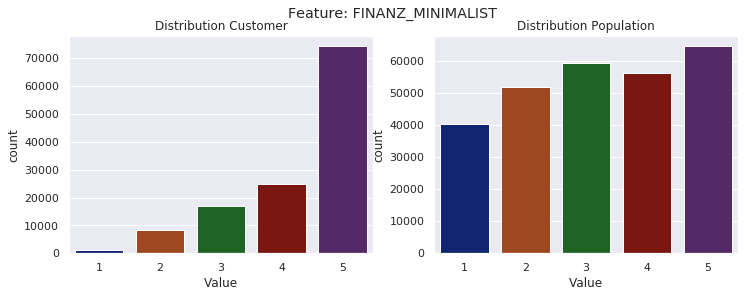

In [48]:
plot_compare_feat('FINANZ_MINIMALIST', customers_p , azdias_p)

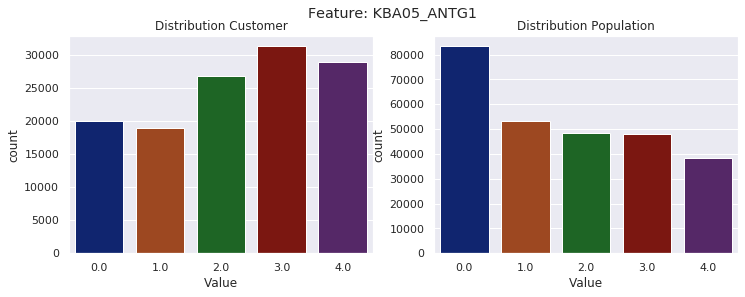

In [56]:
plot_compare_feat('KBA05_ANTG1', customers_p , azdias_p)

In [ ]:
#%%time
#file_customers= Path('customers.h5')
#if file_customers.is_file():
#    print ("load compressed customers file")
#else:
#    print ("compress data frame")
#    customers.to_hdf(file_customers, key='customers', mode='w')

#customers = pd.read_hdf(file_customers, 'customers')

#file_azdias= Path('azdias.h5')
#if file_azdias.is_file():
#    print ("load compressed azdias file")
#else:
#    print ("compress azdias data frame")
#    azdias.to_hdf(file_azdias, key='azdias', mode='w')

#azdias = pd.read_hdf(file_azdias, 'azdias')
#print('load csv')
#azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str',19:'str'}) 
#azdias = pd.read_pickle(file_demographics)
#azdias.head(2)
#azdias.info()

#%%time

#customers[feat_not_described].median()
#print(customers.median().to_string())
#azdias.ALTER_KIND1.value_counts(dropna=False)
#azdias.TITEL_KZ.isnull().sum()
#azdias.KK_KUNDENTYP.value_counts(dropna=False)


In [81]:
corr_azdias = azdias_p.corr().abs()

['ANZ_STATISTISCHE_HAUSHALTE', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'PRAEGENDE_JUGENDJAHRE_BEWEGUNG']
D19_VERSI_ONLINE_QUOTE_12    0.000225
KBA13_SEG_OBERKLASSE         0.001156
D19_TELKO_ANZ_24             0.001312
KBA13_BMW                    0.001318
D19_VERSI_ONLINE_DATUM       0.002047
                               ...   
FINANZ_HAUSBAUER             0.649923
KBA05_ANTG1                  0.652187
HH_EINKOMMEN_SCORE           0.685328
FINANZ_MINIMALIST            0.763834
LP_STATUS_FEIN               0.985991
Name: LP_STATUS_GROB, Length: 297, dtype: float64


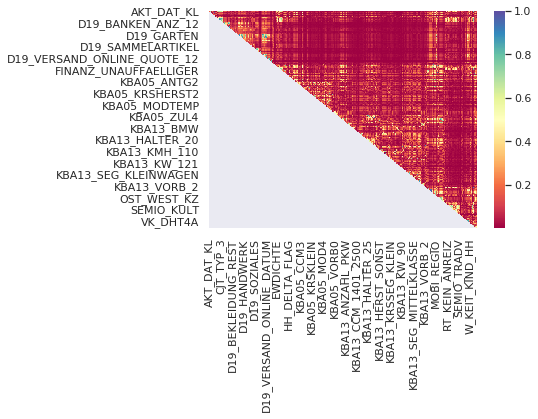

In [82]:
# find correlated variables which can possibly be removed
df_ut = corr_azdias.where(np.triu(np.ones(corr_azdias.shape),k=1).astype(np.bool))
hmap=sns.heatmap(df_ut,cmap="Spectral")
#df_ut.head()
#df_ut.AGER_TYP
drop_columns = [column for column in df_ut.columns if any(df_ut[column] > .95)]
print ((drop_columns))
print (df_ut.LP_STATUS_GROB.dropna().sort_values(ascending=True))